In [ ]:
# 2017-10-03 baseline (only)                         --> LB=0.78
# 2017-10-03 baseline with lemmarization (pymorphy2) --> LB=0.83991
# 2017-10-03 baseline + lemmarization (pymorphy2)

In [201]:
from __future__ import division
import pandas as pd
from collections import Counter
import functools
#import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as skm
import pymorphy2

In [202]:
dftrain, dftest = pd.read_csv("../Data/train_task1_latest.csv"), pd.read_csv("../Data/test_task1_latest.csv")

In [203]:
dftrain.shape, dftest.shape, dftrain.columns.tolist()

((119398, 5),
 (74294, 4),
 ['paragraph_id', 'question_id', 'paragraph', 'question', 'target'])

In [204]:
print(dftrain.paragraph[0])
mm2 = pymorphy2.MorphAnalyzer()
mm2.parse(u'вова')
print mm2.parse(u'вову')[0].normal_form

[mm2.parse(xx)[0].normal_form for xx in re.findall("\w+", (dftrain.paragraph[0]).decode('utf-8'),re.UNICODE) if mm2.parse(xx)[0].tag.POS in {'PREP','CONJ','PRCL'}] 
for xx in [mm2.parse(xx)[0].normal_form for xx in re.findall("\w+", (dftrain.paragraph[0]).decode('utf-8'),re.UNICODE) if mm2.parse(xx)[0].tag.POS not in {'PREP','CONJ','PRCL'}]  :
    print xx
        

В отличие от рыб, земноводные (амфибии) и пресмыкающиеся (рептилии или гады) уже имеют два круга кровообращения и сердце у них трёхкамерное (появляется межпредсердная перегородка). Единственные современные рептилии, имеющие хотя и неполноценное (межпредсердиевая перегородка не полностью разделяет предсердия, что скорей всего связано с переходом предков к полуводному образу жизни и снижению активности), но уже четырёхкамерное сердце — крокодилы. Считается, что впервые четырёхкамерное сердце появилось у примитивных архозавров и развитых синапсидов. В дальнейшем такое строение сердца унаследовали прямые потомки динозавров — птицы и потомки примитивных млекопитающих — современные млекопитающие.
вова
отличие
рыба
земноводный
амфибия
пресмыкаться
рептилия
гад
уже
иметь
два
круг
кровообращение
сердце
они
трёхкамерный
появляться
межпредсердный
перегородка
единственный
современный
рептилия
иметь
неполноценный
межпредсердиевый
перегородка
полностью
разделять
предсердие
скорый
всего
связать
перех

In [205]:
#@functools.lru_cache(maxsize=2 ** 19)
def uniq_words_old_baseline(text):
    return set(re.findall("\w+", text.decode('utf-8'),re.UNICODE))

def calculate_idfs_old_baseline(data):
    counter_paragraph = Counter()
    uniq_paragraphs = data['paragraph'].unique()
    for paragraph in uniq_paragraphs : #tqdm.tqdm(uniq_paragraphs, desc="calc idf"):
        set_words = uniq_words_old_baseline(paragraph)
        counter_paragraph.update(set_words)
        
    num_docs = uniq_paragraphs.shape[0]
    idfs = {}
    for word in counter_paragraph:
        idfs[word] = np.log(float(num_docs) // counter_paragraph[word])
    return idfs

In [206]:
#@functools.lru_cache(maxsize=2 ** 19)
def uniq_words(text):
    ttext = [mm2.parse(xx)[0].normal_form for xx in re.findall("\w+", text.decode('utf-8'),re.UNICODE) 
             if mm2.parse(xx)[0].tag.POS not in {'PREP','CONJ','PRCL','INTJ'}]
    return  set(ttext)
    #return set(re.findall("\w+", text.decode('utf-8'),re.UNICODE))

def calculate_idfs(data):
    counter_paragraph = Counter()
    uniq_paragraphs = data['paragraph'].unique()
    for paragraph in uniq_paragraphs : #tqdm.tqdm(uniq_paragraphs, desc="calc idf"):
        set_words = uniq_words(paragraph)
        counter_paragraph.update(set_words)
        
    num_docs = uniq_paragraphs.shape[0]
    idfs = {}
    for word in counter_paragraph:
        idfs[word] = np.log(float(num_docs) // counter_paragraph[word])
    return idfs

In [207]:
idfs  = calculate_idfs(dftrain)
idfs0 = calculate_idfs_old_baseline(dftrain)

In [208]:
dftrain[:1]

,paragraph_id,question_id,paragraph,question,target
0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0


In [209]:
print(dftrain.paragraph[0])

В отличие от рыб, земноводные (амфибии) и пресмыкающиеся (рептилии или гады) уже имеют два круга кровообращения и сердце у них трёхкамерное (появляется межпредсердная перегородка). Единственные современные рептилии, имеющие хотя и неполноценное (межпредсердиевая перегородка не полностью разделяет предсердия, что скорей всего связано с переходом предков к полуводному образу жизни и снижению активности), но уже четырёхкамерное сердце — крокодилы. Считается, что впервые четырёхкамерное сердце появилось у примитивных архозавров и развитых синапсидов. В дальнейшем такое строение сердца унаследовали прямые потомки динозавров — птицы и потомки примитивных млекопитающих — современные млекопитающие.


In [210]:
paragraph = uniq_words(str(dftrain.paragraph[0]));
print len(paragraph)
for xx in paragraph : print xx

53
предок
динозавр
переход
жизнь
межпредсердиевый
единственный
связать
полуводный
пресмыкаться
перегородка
снижение
дальнейший
межпредсердный
такой
строение
появляться
появиться
синапсид
унаследовать
крокодил
отличие
неполноценный
млекопитающее
два
считаться
впервые
иметь
образ
рыба
кровообращение
птица
активность
архозавр
уже
гад
полностью
амфибия
всего
предсердие
трёхкамерный
рептилия
развитый
скорый
современный
примитивный
сердце
круг
прямая
они
разделять
земноводный
четырёхкамерный
потомок


In [211]:
for name, df in [('train', dftrain), ('test', dftest)]:
    for index, row in df.iterrows() : #tqdm.tqdm(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        
        question = uniq_words(row.question)
        paragraph = uniq_words(row.paragraph)
        df.loc[index, 'len_paragraph'] = len(paragraph)
        df.loc[index, 'len_question'] = len(question)
        df.loc[index, 'len_intersection'] = len(paragraph & question)
        df.loc[index, 'idf_question'] = np.sum([idfs.get(word, 0.0) for word in question])
        df.loc[index, 'idf_paragraph'] = np.sum([idfs.get(word, 0.0) for word in paragraph])
        df.loc[index, 'idf_intersection'] = np.sum([idfs.get(word, 0.0) for word in paragraph & question])
        
        question = uniq_words_old_baseline(row.question)
        paragraph = uniq_words_old_baseline(row.paragraph)
        df.loc[index, 'len_paragraph0'] = len(paragraph)
        df.loc[index, 'len_question0'] = len(question)
        df.loc[index, 'len_intersection0'] = len(paragraph & question)
        df.loc[index, 'idf_question0'] = np.sum([idfs0.get(word, 0.0) for word in question])
        df.loc[index, 'idf_paragraph0'] = np.sum([idfs0.get(word, 0.0) for word in paragraph])
        df.loc[index, 'idf_intersection0'] = np.sum([idfs0.get(word, 0.0) for word in paragraph & question])

In [212]:
dftrain.tail()

,paragraph_id,question_id,paragraph,question,target,len_paragraph,len_question,len_intersection,idf_question,idf_paragraph,idf_intersection,len_paragraph0,len_question0,len_intersection0,idf_question0,idf_paragraph0,idf_intersection0
119393,787,78704,"С VIII века, как для Везера, так и для Верра, ...",Какие новые спортивные сооружения были построе...,0.0,100.0,9.0,1.0,35.776788,530.746033,0.693147,134.0,11.0,3.0,39.611780,729.865475,3.044522
119394,7414,97752,В 1049 году Балдуину V удалось отнять у Герман...,В каком году умер Райан Уайт?,0.0,66.0,5.0,2.0,24.108538,347.932991,5.411646,89.0,6.0,3.0,28.438558,496.188281,6.473891
119395,3845,2104,Клиническая фармакология изучает воздействие л...,Когда на всемирном конгрессе немецких школ за ...,0.0,54.0,10.0,0.0,38.485331,247.637943,0.000000,74.0,14.0,3.0,66.305302,381.707501,4.941642
119396,168,92509,Сложность выделения чистых белков затрудняла и...,Что в конце 1940-х — начале 1950-х годов разра...,0.0,50.0,9.0,4.0,38.253560,231.631415,10.477006,63.0,11.0,5.0,50.299845,324.672574,13.735103
119397,2679,41770,"У типичной свободной программы (то есть, неком...",с каким персонажем происходит схватка Шерлока ...,0.0,63.0,10.0,0.0,54.902711,260.877884,0.000000,86.0,13.0,3.0,68.846945,442.699187,0.000000


In [213]:
columns = ['len_paragraph', 'len_question', 'len_intersection', 'idf_question', 'idf_paragraph', 'idf_intersection']
model = GradientBoostingClassifier().fit(dftrain[columns], dftrain['target'])
dftest['prediction']  = model.predict_proba(dftest[columns])[:, 1]
ddftrain = model.predict_proba(dftrain[columns])[:, 1]

In [214]:
dftest[['paragraph_id', 'question_id', 'prediction']].head()

,paragraph_id,question_id,prediction
0,1361,6463,0.001339
1,1403,34696,0.623654
2,1435,13751,0.005001
3,341,38544,0.991724
4,1317,14589,0.244543


In [216]:
dftest[['paragraph_id', 'question_id', 'prediction']].to_csv("../Result/prediction-base-lex.csv", index=False)

In [197]:
dftrain.target[:10]
ddftrain[:10]

array([ 0.00131852,  0.00131852,  0.00147645,  0.00263949,  0.45595856,
        0.00131852,  0.00461315,  0.97914795,  0.99597451,  0.0035394 ])

0.970108377025


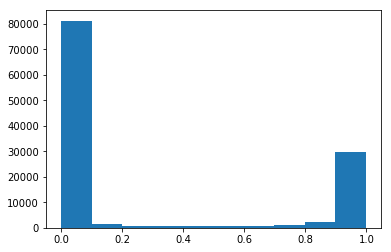

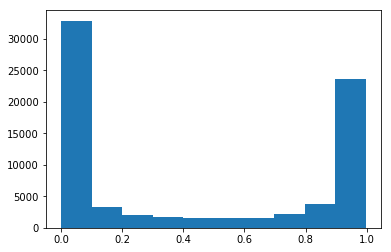

In [215]:
print skm.accuracy_score(dftrain['target'].values,ddftrain>0.5)
plt.hist(ddftrain); plt.show()
plt.hist(dftest['prediction']); plt.show()

0.970351262165


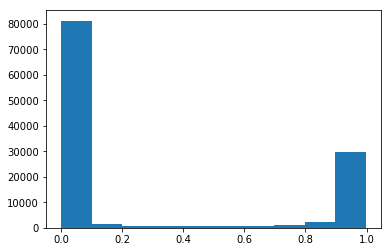

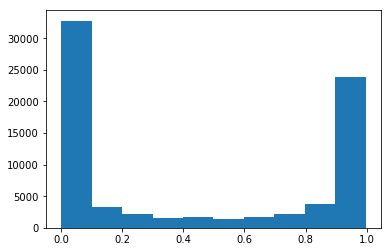

In [198]:
print skm.accuracy_score(dftrain['target'].values,ddftrain>0.5)
plt.hist(ddftrain); plt.show()
plt.hist(dftest['prediction']); plt.show()

0.973935911824


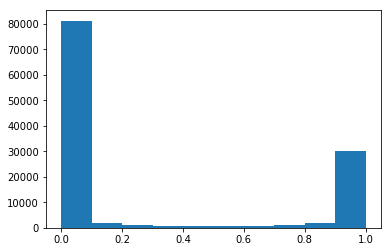

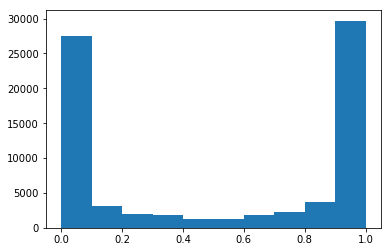

In [145]:
print skm.accuracy_score(dftrain['target'].values,ddftrain>0.5)
plt.hist(ddftrain); plt.show()
plt.hist(dftest['prediction']); plt.show()

In [28]:
aa=Counter('aabb bcccc'); aa
#aa=Counter({'aa':6, 'b':7}); aa

Counter({' ': 1, 'a': 2, 'b': 3, 'c': 4})

In [85]:
import pymorphy2
morphy = pymorphy2.MorphAnalyzer()
morphy.parse(u'вова')
print morphy.parse(u'вову')[0].normal_form
#str(morphy.parse(u'вовочка')[0].normal_form) #.encode('cp1251')

вова


In [112]:
wword = u'четвертый пересидевший'
print len(morphy.parse(wword)),morphy.parse(wword)
print morphy.parse(wword)[0].normal_form
for pp in morphy.parse(wword) : print pp.normal_form, pp.score, pp.tag

4 [Parse(word=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0432\u0448\u0438\u0439', tag=OpencorporaTag('PRTF,perf,intr,past,actv masc,sing,nomn'), normal_form=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0442\u044c', score=0.4831932773109244, methods_stack=((<FakeDictionary>, u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0432\u0448\u0438\u0439', 715, 15), (<KnownSuffixAnalyzer>, u'\u0435\u0432\u0448\u0438\u0439'))), Parse(word=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0432\u0448\u0438\u0439', tag=OpencorporaTag('PRTF,perf,intr,past,actv inan,masc,sing,accs'), normal_form=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0442\u044c', score=0.4831932773109244, methods_stack=((<FakeDicti

In [75]:
print unicode(u'вщвщчка')
#str(u'вщвщчка'.decode('utf_8'))

вщвщчка


In [74]:
print 'вовочка'.decode('utf-8')

вовочка


In [200]:
import nltk